Differential Diagnosis of COPD and Asthma

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import librosa
import librosa.display
import os
import shutil
from os import listdir
from os.path import isfile, join
from sklearn.model_selection import train_test_split

Disease
N                                 35
Asthma                            17
asthma                            15
heart failure                     15
COPD                               8
pneumonia                          5
Lung Fibrosis                      4
BRON                               3
Heart Failure                      3
Plueral Effusion                   2
Heart Failure + COPD               2
Heart Failure + Lung Fibrosis      1
Asthma and lung fibrosis           1
copd                               1
Name: count, dtype: int64


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 [Text(0, 0, 'Asthma'),
  Text(1, 0, 'Heart Failure + Lung Fibrosis '),
  Text(2, 0, 'Heart Failure + COPD'),
  Text(3, 0, 'Plueral Effusion'),
  Text(4, 0, 'Heart Failure'),
  Text(5, 0, 'heart failure'),
  Text(6, 0, 'COPD'),
  Text(7, 0, 'pneumonia'),
  Text(8, 0, 'Asthma and lung fibrosis'),
  Text(9, 0, 'BRON'),
  Text(10, 0, 'Lung Fibrosis'),
  Text(11, 0, 'copd'),
  Text(12, 0, 'asthma'),
  Text(13, 0, 'N')])

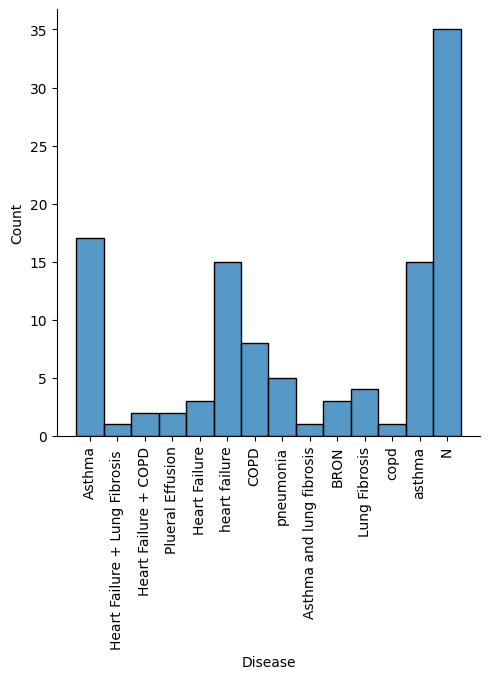

In [3]:
diagnosis_data = pd.read_excel(r"C:\Users\chatt\Desktop\Project\KAUH Dataset\Data annotation.xlsx", usecols='B, E',names=['Sex','Disease'])
diagnosis_data.head(4)
print (diagnosis_data.Disease.value_counts())
sns.displot(diagnosis_data.Disease)
#sns.countplot(diagnosis_data.Diagnosis.value_counts())
plt.xticks(rotation=90)

In [4]:
mypath = r"C:\Users\chatt\Desktop\Project\KAUH Dataset\Audio Files"
filenames = [f for f in listdir(mypath) if (isfile(join(mypath, f)) and f.endswith('.wav'))] 
filepaths = [join(mypath, f) for f in filenames] 
print(filepaths)

['C:\\Users\\chatt\\Desktop\\Project\\KAUH Dataset\\Audio Files\\BP100_N,N,P R M,70,F.wav', 'C:\\Users\\chatt\\Desktop\\Project\\KAUH Dataset\\Audio Files\\BP101_Asthma,E W,P L M,12,F.wav', 'C:\\Users\\chatt\\Desktop\\Project\\KAUH Dataset\\Audio Files\\BP102_N,N,P L L,41,M.wav', 'C:\\Users\\chatt\\Desktop\\Project\\KAUH Dataset\\Audio Files\\BP103_N,N,P R U,81,F.wav', 'C:\\Users\\chatt\\Desktop\\Project\\KAUH Dataset\\Audio Files\\BP104_Asthma,E W,P L U,45,F.wav', 'C:\\Users\\chatt\\Desktop\\Project\\KAUH Dataset\\Audio Files\\BP105_Lung Fibrosis,Crep,A U R,44,M.wav', 'C:\\Users\\chatt\\Desktop\\Project\\KAUH Dataset\\Audio Files\\BP106_Asthma,E W,P L U,45,F.wav', 'C:\\Users\\chatt\\Desktop\\Project\\KAUH Dataset\\Audio Files\\BP107_Asthma,E W,P L U,59,F.wav', 'C:\\Users\\chatt\\Desktop\\Project\\KAUH Dataset\\Audio Files\\BP108_COPD,E W,P R L ,63,M.wav', 'C:\\Users\\chatt\\Desktop\\Project\\KAUH Dataset\\Audio Files\\BP109_N,N,P L M,26,M.wav', 'C:\\Users\\chatt\\Desktop\\Project\\KAU

In [5]:
def Name_Access(Filename):
    """
    Extracts disease name from the filename.
    Args:
        Filename (str): The filename string to process.
    Returns:
        list: A list containing a tuple with (disease_name, has_plus_flag) or an empty list if filename format is invalid.
    """
    parts = Filename.split("\\")  # Split on backslash for Windows paths
    if len(parts) > 4:
        file_name = parts[-1]  # Get the last part (actual filename)
        disease_name = file_name.split("_")[1].split(",")[0]  # Extract disease name
        has_plus = "+" in disease_name
        return [(disease_name, str(has_plus))]
    return []

# Assuming filepaths is a list of valid filenames
Asthma = COPD = HeartFailure = BRON = Pneumonia = LungFibrosis = Trash = Normal = PleuralEffusion = 0

for soundDir in filepaths:
    Diseases = Name_Access(soundDir)
    if Diseases:
        disease = Diseases[0][0].lower()
        if disease == "asthma":
            Asthma += 1
        elif disease in ["heart failure", "heart_failure"]:
            HeartFailure += 1
        elif disease == "copd":
            COPD += 1
        elif disease == "bron":
            BRON += 1
        elif disease == "pneumonia":
            Pneumonia += 1
        elif disease == "lung fibrosis":
            LungFibrosis += 1
        elif disease == "pleural effusion":
            PleuralEffusion += 1
        elif disease == "n":
            Normal += 1
        else:
            Trash += 1
    else:
        print(f"Error processing file: {soundDir}")

print("Asthma", Asthma)
print("HeartFailure", HeartFailure)
print("COPD", COPD)
print("BRON", BRON)
print("LungFibrosis", LungFibrosis)
print("PleuralEffusion", PleuralEffusion)
print("Pneumonia", Pneumonia)
print("Normal", Normal)
print("Trash", Trash)

Asthma 96
HeartFailure 54
COPD 27
BRON 9
LungFibrosis 12
PleuralEffusion 0
Pneumonia 15
Normal 105
Trash 18


In [6]:
pip install tqdm


[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
import numpy as np
import librosa
import os
from tqdm import tqdm  # Progress bar for processing files

# ===========================================
# 🔹 FRAME SEGMENTATION FUNCTION
# ===========================================
def segment_signal(signal, sr, frame_length=20, overlap_ratio=0.4):
    """
    Splits lung sound signal into frames of specified length with given overlap.
    
    Parameters:
        - signal: Raw lung sound signal (1D NumPy array).
        - sr: Sampling rate of the signal.
        - frame_length: Frame duration in seconds (default=20 sec).
        - overlap_ratio: Percentage of overlap between frames (default=40%).
    
    Returns:
        - List of framed signals.
    """
    frame_size = int(sr * frame_length)  # Convert seconds to samples
    step_size = int(frame_size * (1 - overlap_ratio))  # Step between frames

    frames = []
    for start in range(0, len(signal) - frame_size, step_size):
        frames.append(signal[start:start + frame_size])
    
    return np.array(frames)


# ===========================================
# 🔹 BASELINE WANDER REMOVAL USING DFT
# ===========================================
def remove_baseline_wander(signal, sr, cutoff_freq=1):
    """
    Removes baseline wander noise (0-1 Hz) using Discrete Fourier Transform (DFT).
    
    Parameters:
        - signal: Input frame signal.
        - sr: Sampling rate.
        - cutoff_freq: Frequency below which DFT coefficients are removed.
    
    Returns:
        - Filtered signal after inverse DFT.
    """
    M = len(signal)  # DFT length
    freqs = np.fft.fftfreq(M, d=1/sr)  # Frequency bins
    dft_coeffs = np.fft.fft(signal)  # Compute DFT

    # Find indices of low-frequency components (0-1 Hz) and set them to zero
    dft_coeffs[np.abs(freqs) < cutoff_freq] = 0

    # Reconstruct signal using inverse DFT
    filtered_signal = np.fft.ifft(dft_coeffs).real
    return filtered_signal


# ===========================================
# 🔹 PREPROCESSING FUNCTION FOR DATASET
# ===========================================
def preprocess_dataset(folder_path, sr=22050):
    """
    Processes all .wav files in a folder:
    - Segments each audio file into frames.
    - Removes baseline wander using DFT filtering.
    
    Parameters:
        - folder_path: Path to dataset folder containing .wav files.
        - sr: Sampling rate for librosa loading (default=22050 Hz).
    
    Returns:
        - Dictionary with file names as keys and processed frames as values.
    """
    processed_data = {}  # Store preprocessed frames

    # Get all .wav files in the dataset folder
    wav_files = [f for f in os.listdir(folder_path) if f.endswith(".wav")]
    
    print(f"🔍 Found {len(wav_files)} .wav files. Processing...")
    
    for filename in tqdm(wav_files, desc="Processing Files"):
        file_path = os.path.join(folder_path, filename)

        # Load the lung sound signal
        signal, sr = librosa.load(file_path, sr=sr)
        
        # Segment signal into overlapping frames
        frames = segment_signal(signal, sr)

        # Apply baseline wander removal to each frame
        processed_frames = np.array([remove_baseline_wander(frame, sr) for frame in frames])

        # Store the processed frames
        processed_data[filename] = processed_frames

    print("✅ Preprocessing completed!")
    return processed_data, sr


# ===========================================
# ✅ RUN PREPROCESSING ON WHOLE DATASET
# ===========================================
dataset_path = r"C:\Users\chatt\Desktop\Project\KAUH Dataset\Audio Files"  # Change to the folder containing .wav files
preprocessed_data, sampling_rate = preprocess_dataset(dataset_path)

# Example: Access preprocessed frames of a specific file
example_filename = list(preprocessed_data.keys())[0]  # First processed file
print(f"🔹 Processed frames for {example_filename}: {preprocessed_data[example_filename].shape}")


🔍 Found 336 .wav files. Processing...


Processing Files: 100%|██████████| 336/336 [00:14<00:00, 23.30it/s]

✅ Preprocessing completed!
🔹 Processed frames for BP100_N,N,P R M,70,F.wav: (0,)


In [8]:
def add_noise(data,x):
    noise = np.random.randn(len(data))
    data_noise = data + x * noise
    return data_noise

def shift(data,x):
    return np.roll(data, x)

def stretch(data,strate):
    data = librosa.effects.time_stretch(data,rate=strate)
    return data

def pitch_shift (data ,sampling_r, rate):
    data = librosa.effects.pitch_shift(data, sr=sampling_r, n_steps=rate)
    return data

In [9]:
import numpy as np
import librosa
import os
from tqdm import tqdm
from scipy.signal import firwin, lfilter

# ===========================================
# 🔹 APPLY FIR FILTER FOR DENOISING
# ===========================================
def apply_fir_filter(signal, sr, cutoff=500, num_taps=101, filter_type="lowpass"):
    """Apply FIR filter to remove high-frequency noise from lung sound signals."""
    nyquist = sr / 2  
    if filter_type == "lowpass":
        fir_coeff = firwin(num_taps, cutoff / nyquist, pass_zero=True)
    elif filter_type == "bandpass":
        if isinstance(cutoff, list) and len(cutoff) == 2:
            fir_coeff = firwin(num_taps, [cutoff[0] / nyquist, cutoff[1] / nyquist], pass_zero=False)
        else:
            raise ValueError("For bandpass filter, cutoff must be a list of two values [low, high].")
    else:
        raise ValueError("filter_type must be 'lowpass' or 'bandpass'.")
    
    return lfilter(fir_coeff, 1.0, signal)

# ===========================================
# 🔹 EXTRACT MEL-SPECTROGRAM FEATURES (3D)
# ===========================================
def extract_mel_spectrogram(data, sr, n_mels=128, hop_length=512):
    """Convert an audio signal into a 3D Mel-Spectrogram."""
    mel_spec = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=n_mels, hop_length=hop_length)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)  # Convert to dB scale

    # ✅ Ensure Fixed Shape (128, 100)
    if mel_spec_db.shape[1] < 100:  # Pad if too short
        pad_width = 100 - mel_spec_db.shape[1]
        mel_spec_db = np.pad(mel_spec_db, ((0, 0), (0, pad_width)), mode='constant')
    elif mel_spec_db.shape[1] > 100:  # Trim if too long
        mel_spec_db = mel_spec_db[:, :100]

    return mel_spec_db  # Shape: (128, 100)

# ===========================================
# 🔹 FEATURE EXTRACTION FUNCTION
# ===========================================
def feature_extraction(dir_):
    """
    Extracts Mel-Spectrograms with FIR filtering and Data Augmentation.
    """
    X_Features = []
    y_Labels = []
    
    target_count = 150  # ✅ Ensure Asthma and COPD both reach ~150

    disease_counts = {"Asthma": 0, "COPD": 0, "Healthy": 0}

    for soundDir in tqdm(dir_):
        Diseases = Name_Access(soundDir)  # Extract labels correctly
        if Diseases:
            disease = Diseases[0][0].lower()
            
            if disease in ["asthma", "copd", "n"]:  # ✅ Removed Pneumonia
                data, sampling_rate = librosa.load(soundDir)

                # ✅ Apply FIR Filter
                filtered_signal = apply_fir_filter(data, sampling_rate)

                # ✅ Compute Mel-Spectrogram Features
                mel_spec = extract_mel_spectrogram(filtered_signal, sampling_rate)

                # ✅ Ensure 3D Shape
                mel_spec = np.expand_dims(mel_spec, axis=-1)  # Shape (128, 100, 1)
                
                # ✅ Assign Disease Labels
                disease_label = "Asthma" if disease == "asthma" else "COPD" if disease == "copd" else "Healthy"

                # ✅ Store Original Data for All Classes
                X_Features.append(mel_spec)
                y_Labels.append(disease_label)
                disease_counts[disease_label] += 1

                # ✅ Apply Data Augmentation for Asthma & COPD until ~150
                if disease_label in ["Asthma", "COPD"]:
                    while disease_counts[disease_label] < target_count:
                        aug_type = np.random.choice(["noise", "shift", "stretch", "pitch"])
                        data_aug = filtered_signal.copy()

                        if aug_type == "noise":
                            data_aug = add_noise(data_aug, x=0.005)
                        elif aug_type == "shift":
                            data_aug = shift(data_aug, x=np.random.randint(100)) 
                        elif aug_type == "stretch":
                            data_aug = stretch(data_aug, strate=np.random.uniform(0.8, 1.2)) 
                        elif aug_type == "pitch":
                            data_aug = pitch_shift(data_aug, sampling_rate, rate=np.random.randint(-3, 3))

                        # ✅ Extract Mel-Spectrogram for Augmented Data
                        mel_spec_aug = extract_mel_spectrogram(data_aug, sampling_rate)

                        # ✅ Ensure 3D Shape
                        mel_spec_aug = np.expand_dims(mel_spec_aug, axis=-1)

                        X_Features.append(mel_spec_aug)
                        y_Labels.append(disease_label)
                        disease_counts[disease_label] += 1

    # ✅ Convert to NumPy Arrays
    X_data = np.array(X_Features)
    y_data = np.array(y_Labels)

    print("✅ Final Dataset Counts:", disease_counts)
    
    return X_data, y_data 

# ===========================================
# ✅ RUN FEATURE EXTRACTION
# ===========================================
X_data, y_data = feature_extraction(filepaths)

# ✅ Print Final Shapes
print(f"\n✅ Feature Matrix Shape: {X_data.shape}")  # Expected (num_samples, 128, 100, 1)
print(f"✅ Labels Shape: {y_data.shape}")


100%|██████████| 336/336 [00:38<00:00,  8.72it/s]

✅ Final Dataset Counts: {'Asthma': 245, 'COPD': 176, 'Healthy': 105}

✅ Feature Matrix Shape: (526, 128, 100, 1)
✅ Labels Shape: (526,)


In [10]:
x_mfccs_fb, y_mfccs = feature_extraction(filepaths)
print(x_mfccs_fb.shape)

100%|██████████| 336/336 [01:18<00:00,  4.27it/s]

✅ Final Dataset Counts: {'Asthma': 245, 'COPD': 176, 'Healthy': 105}
(526, 128, 100, 1)


In [11]:
def augmented_data_count(lables):
    unique, counts = np.unique(lables, return_counts=True)
    data_count = dict(zip(unique, counts))

    data = data_count

    courses = list(data.keys())
    values = list(data.values())

    fig = plt.figure(figsize = (10, 5))
    
    plt.bar(courses, values, color =['orange','green','blue','red','yellow','black'],
            width = 0.4)

    plt.xlabel("Diseases")
    plt.ylabel("Count")
    plt.title("Count of each disease")
    plt.show()

    print (data_count)


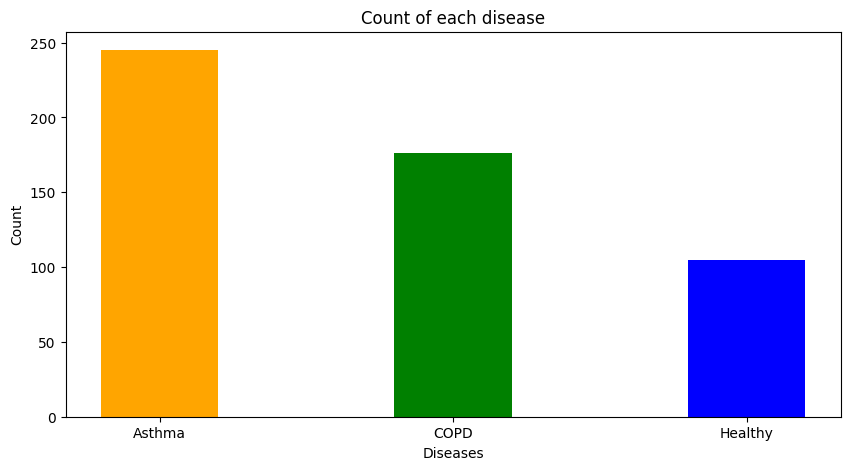

{np.str_('Asthma'): np.int64(245), np.str_('COPD'): np.int64(176), np.str_('Healthy'): np.int64(105)}


In [12]:
augmented_data_count(y_mfccs)

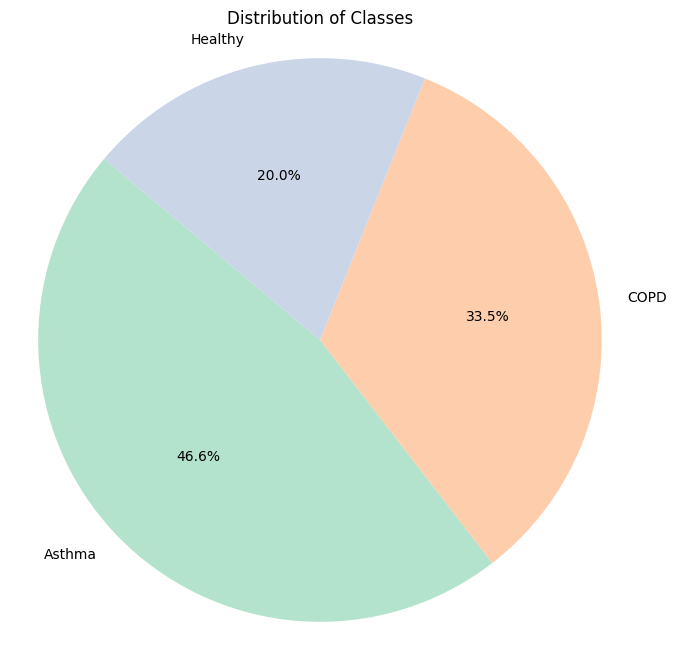

{np.str_('Asthma'): np.int64(245), np.str_('COPD'): np.int64(176), np.str_('Healthy'): np.int64(105)}


In [13]:
def augmented_data_count(labels):
    unique, counts = np.unique(labels, return_counts=True)
    data_count = dict(zip(unique, counts))

    data = data_count

    courses = list(data.keys())
    values = list(data.values())

    fig = plt.figure(figsize=(8, 8))

    # Create a pie chart
    plt.pie(values, labels=courses, autopct='%1.1f%%', startangle=140, colors=plt.cm.Pastel2.colors)
    
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title("Distribution of Classes")
    plt.show()

    print(data_count)

# Usage
augmented_data_count(y_mfccs)

In [14]:
y_data_encode = y_mfccs.reshape(y_mfccs.shape[0], 1)

y_data_encode = np.where(y_data_encode == 'COPD', np.array([1,0,0]).reshape(1,3), y_data_encode)
y_data_encode = np.where(y_data_encode == 'Asthma', np.array([0,1,0]).reshape(1,3), y_data_encode)
y_data_encode = np.where(y_data_encode == 'Healthy', np.array([0,0,1]).reshape(1,3), y_data_encode)

Y_data = y_data_encode.astype('float64')

In [15]:
x_mfccs_fb.shape,Y_data.shape

((526, 128, 100, 1), (526, 3))

In [16]:
# Splitting data into training ,validation and testing sets

mfcc_train, mfcc_val, lables_train, lables_val  = train_test_split(x_mfccs_fb,Y_data , test_size=0.175, random_state=10)
mfcc_train, mfcc_test, lables_train, lables_test = train_test_split(mfcc_train, lables_train, test_size=0.075, random_state=10)

print (mfcc_train.shape, mfcc_val.shape, mfcc_test.shape)
print (lables_train.shape, lables_val.shape, lables_test.shape)

(400, 128, 100, 1) (93, 128, 100, 1) (33, 128, 100, 1)
(400, 3) (93, 3) (33, 3)


In [17]:
x_train_gru = np.expand_dims(mfcc_train,axis=1)
x_val_gru = np.expand_dims(mfcc_val,axis=1)
x_test_gru = np.expand_dims(mfcc_test,axis=1)

y_train_gru = np.expand_dims(lables_train,axis=1)
y_val_gru = np.expand_dims(lables_val,axis=1)
y_test_gru = np.expand_dims(lables_test,axis=1)

In [18]:
print(x_mfccs_fb) 

[[[[ -7.69199773]
   [ -6.27670111]
   [ -5.94361862]
   ...
   [ -8.11575977]
   [-13.42661582]
   [ -4.40653177]]

  [[-12.37765859]
   [-10.19214913]
   [-13.80504747]
   ...
   [-16.89298351]
   [-17.75661072]
   [-10.91333043]]

  [[-21.74232736]
   [-19.70230941]
   [-22.45419442]
   ...
   [-28.86083163]
   [-26.06798703]
   [-24.24145843]]

  ...

  [[-80.        ]
   [-80.        ]
   [-80.        ]
   ...
   [-80.        ]
   [-80.        ]
   [-80.        ]]

  [[-80.        ]
   [-80.        ]
   [-80.        ]
   ...
   [-80.        ]
   [-80.        ]
   [-80.        ]]

  [[-80.        ]
   [-80.        ]
   [-80.        ]
   ...
   [-80.        ]
   [-80.        ]
   [-80.        ]]]


 [[[ -7.69199773]
   [ -6.27670111]
   [ -5.94361862]
   ...
   [ -8.11575977]
   [-13.42661582]
   [ -4.40653177]]

  [[-12.37765859]
   [-10.19214913]
   [-13.80504747]
   ...
   [-16.89298351]
   [-17.75661072]
   [-10.91333043]]

  [[-21.74232736]
   [-19.70230941]
   [-22.45419442]
 

In [19]:
print("x_train_gru shape:", x_train_gru.shape)
print("y_train_gru shape:", y_train_gru.shape)
print("x_train_gru dtype:", x_train_gru.dtype)
print("y_train_gru dtype:", y_train_gru.dtype)

x_train_gru shape: (400, 1, 128, 100, 1)
y_train_gru shape: (400, 1, 3)
x_train_gru dtype: float64
y_train_gru dtype: float64


In [20]:
x_train_gru = np.reshape(x_train_gru, (400, 100, 128))
x_val_gru = np.reshape(x_val_gru, (x_val_gru.shape[0], 100, 128))


In [21]:
print(x_train_gru.shape)  # Should print (400, 100, 128)
print(x_val_gru.shape)    # Should match validation size


(400, 100, 128)
(93, 100, 128)


In [22]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import (
    Conv1D, MaxPooling1D, Flatten, Dense, Dropout, 
    Bidirectional, GRU, LeakyReLU, add, Input, BatchNormalization, Reshape
)
from tensorflow.keras.models import Model


In [35]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2

# Simulated Input Shape (Example)
x_train_gru = np.random.rand(400, 100, 128)  # (Batch, Time Steps, Features)
x_val_gru = np.random.rand(100, 100, 128)
y_train_gru = np.random.randint(0, 2, 400)
y_val_gru = np.random.randint(0, 2, 100)

# ✅ Reshape Data to Match CNN Input Requirements
x_train_gru = x_train_gru.reshape(400, 100, 128, 1)  # (Batch, Height, Width, Channels)
x_val_gru = x_val_gru.reshape(100, 100, 128, 1)

# ✅ Define CNN Model
model = Sequential([
    SeparableConv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same',
                    depthwise_regularizer=l2(0.005), pointwise_regularizer=l2(0.005),
                    input_shape=(100, 128, 1)),  # ✅ Correct Input Shape
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    
    SeparableConv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Assuming binary classification
])

# ✅ Compile Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# ✅ Train Model
history = model.fit(x_train_gru, y_train_gru, 
                    epochs=100, batch_size=16, 
                    validation_data=(x_val_gru, y_val_gru))


Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 15s 497ms/step - accuracy: 0.5276 - loss: 5.8031 - val_accuracy: 0.4700 - val_loss: 2.1701
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 549ms/step - accuracy: 0.4707 - loss: 0.8768 - val_accuracy: 0.4700 - val_loss: 1.8411
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 470ms/step - accuracy: 0.5249 - loss: 0.7060 - val_accuracy: 0.4700 - val_loss: 1.7341
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 422ms/step - accuracy: 0.4840 - loss: 0.7353 - val_accuracy: 0.5300 - val_loss: 0.7358
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 412ms/step - accuracy: 0.5559 - loss: 0.7092 - val_accuracy: 0.5300 - val_loss: 0.7478
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 408ms/step - accuracy: 0.5409 - loss: 0.7133 - val_accuracy: 0.5300 - val_loss: 0.7022
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 408ms/step - accuracy: 0.5225 - loss: 0.7149 - val_accuracy: 0.4700 - val_loss: 0.8704
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 409ms/step - accuracy: 0.5698 - loss: 0.6865 - 

Final Training Accuracy: 94.25%
Final Validation Accuracy: 41.00%
Final Training Loss: 0.1337
Final Validation Loss: 4.1366


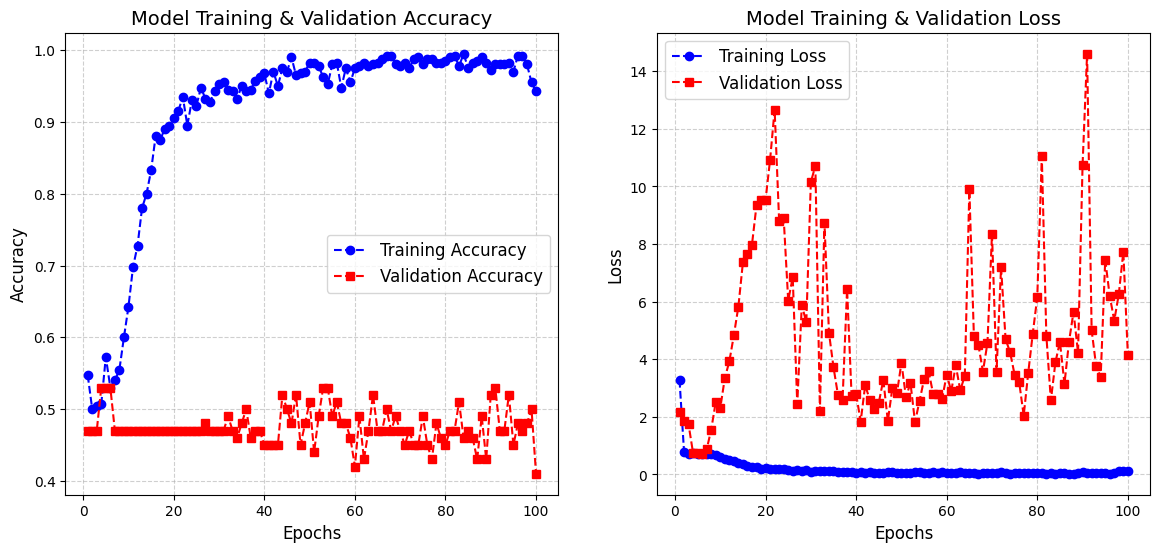

In [36]:
import matplotlib.pyplot as plt

# ✅ Extract Training History
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_acc) + 1)

# ✅ Print Final Accuracy & Loss
print(f"Final Training Accuracy: {train_acc[-1] * 100:.2f}%")
print(f"Final Validation Accuracy: {val_acc[-1] * 100:.2f}%")
print(f"Final Training Loss: {train_loss[-1]:.4f}")
print(f"Final Validation Loss: {val_loss[-1]:.4f}")

# ✅ Plot Accuracy
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, label='Training Accuracy', color='blue', linestyle='dashed', marker='o', markersize=6)
plt.plot(epochs, val_acc, label='Validation Accuracy', color='red', linestyle='dashed', marker='s', markersize=6)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.title("Model Training & Validation Accuracy", fontsize=14)

# ✅ Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Training Loss', color='blue', linestyle='dashed', marker='o', markersize=6)
plt.plot(epochs, val_loss, label='Validation Loss', color='red', linestyle='dashed', marker='s', markersize=6)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.title("Model Training & Validation Loss", fontsize=14)

# ✅ Save & Show Plot
plt.savefig("Training_Validation_Accuracy_Loss100epoch.png", dpi=300, bbox_inches='tight')
plt.show()


✅ Final Training Accuracy: 98.50%
✅ Final Validation Accuracy: 72.04%
✅ Final Training Loss: 0.0446
✅ Final Validation Loss: 1.0068


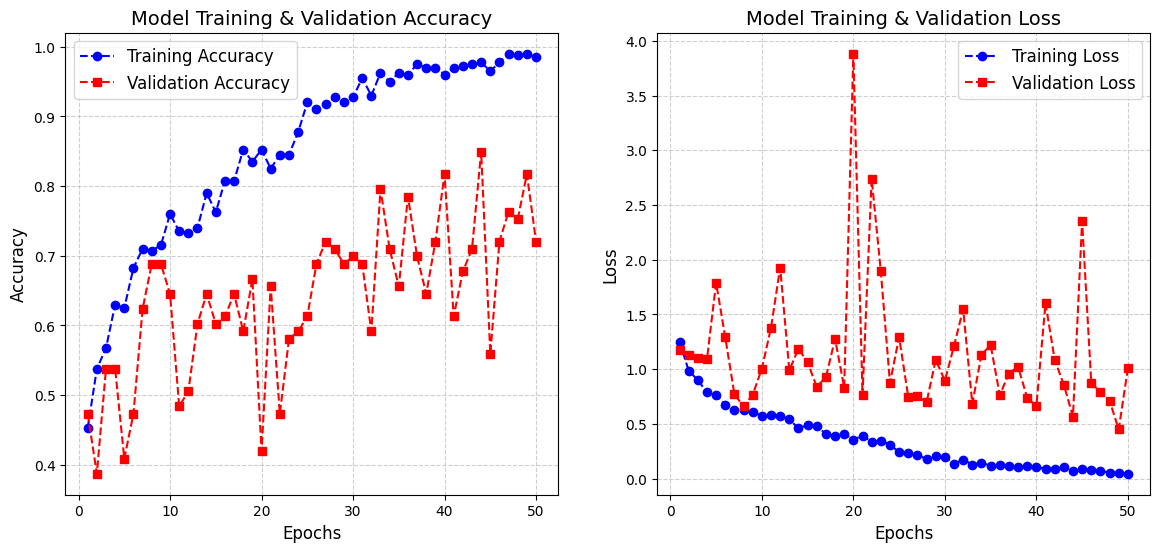

In [ ]:
import matplotlib.pyplot as plt

# ✅ Extract Training History
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_acc) + 1)

# ✅ Print Final Accuracy & Loss
print(f"✅ Final Training Accuracy: {train_acc[-1] * 100:.2f}%")
print(f"✅ Final Validation Accuracy: {val_acc[-1] * 100:.2f}%")
print(f"✅ Final Training Loss: {train_loss[-1]:.4f}")
print(f"✅ Final Validation Loss: {val_loss[-1]:.4f}")

# ✅ Plot Accuracy
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, label='Training Accuracy', color='blue', linestyle='dashed', marker='o', markersize=6)
plt.plot(epochs, val_acc, label='Validation Accuracy', color='red', linestyle='dashed', marker='s', markersize=6)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.title("Model Training & Validation Accuracy", fontsize=14)

# ✅ Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Training Loss', color='blue', linestyle='dashed', marker='o', markersize=6)
plt.plot(epochs, val_loss, label='Validation Loss', color='red', linestyle='dashed', marker='s', markersize=6)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.title("Model Training & Validation Loss", fontsize=14)

# ✅ Save & Show Plot
plt.savefig("Training_Validation_Accuracy_Loss100epoch.png", dpi=300, bbox_inches='tight')
plt.show()
